 Bạn sẽ xây dựng một bộ phân loại hồi quy logistic để nhận dạng mèo. Lab này sẽ hướng dẫn bạn cách thực hiện điều này với tư duy Mạng nơ-ron và do đó cũng sẽ trau dồi trực giác của bạn về deep learning.

**Hướng dẫn:**
- Không sử dụng các vòng lặp (for/while) trong code của bạn, trừ khi các hướng dẫn yêu cầu bạn làm như vậy một cách rõ ràng.

**Bạn sẽ học được:**
- Xây dựng kiến trúc chung của một thuật toán học, bao gồm:
    - Khởi tạo các tham số
    - Tính toán hàm cost và gradient của nó
    - Sử dụng một thuật toán tối ưu hóa (gradient descent)
- Tập hợp cả 3 hàm trên thành một hàm mô hình chính, đúng thứ tự.

## 1 - Thư viện ##

Đầu tiên, hãy chạy cell bên dưới để nhập tất cả các thư viện mà bạn sẽ cần trong lab này.
- [numpy](www.numpy.org) là thư viện cơ bản cho tính toán khoa học với Python.
- [h5py](http://www.h5py.org) là thư viện phổ biến để tương tác với tập dữ liệu được lưu trữ trên tệp H5.
- [matplotlib](http://matplotlib.org) là một thư viện nổi tiếng để vẽ đồ thị trong Python.
- [PIL](http://www.pythonware.com/products/pil/) và [scipy](https://www.scipy.org/) được sử dụng ở đây để kiểm tra mô hình của bạn với hình ảnh ở cuối .

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import imageio
from PIL import Image
from lr_utils import load_dataset

%matplotlib inline

## 2 - Tổng quan về tập Bài toán Overview of the Problem set ##

**Trình bày bài toán**: Cho tập dữ liệu ("data.h5") chứa:
    - tập huấn luyện m_train images được gắn nhãn cat (y=1) hoặc non-cat (y=0)
    - tập kiểm tra m_test images được gắn nhãn cat hoặc non-cat
    - mỗi ảnh có shape (num_px, num_px, 3) trong đó 3 là 3 kênh (RGB). Vì vậy, mỗi hình là hình vuông (chiều cao = num_px) và (chiều rộng = num_px).

Bạn sẽ xây dựng một thuật toán nhận dạng hình ảnh đơn giản có thể phân loại chính xác các bức ảnh là cat (mèo) hay non-cat (không phải mèo).

Hãy làm quen với tập dữ liệu. Tải dữ liệu bằng cách chạy code sau.

In [15]:
# Load dữ liệu (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Chúng ta đã thêm "_orig" vào cuối tập dữ liệu hình ảnh (tập huấn luyện và kiểm tra) vì chúng ta sẽ xử lý trước chúng. Sau tiền xử lý, chúng ta sẽ kết thúc với train_set_x và test_set_x (các nhãn train_set_y và test_set_y không cần tiền xử lý).

Mỗi dòng của train_set_x_orig và test_set_x_orig là một mảng thể hiện một hình ảnh. Bạn có thể hình dung thông qua một ví dụ bằng cách chạy đoạn code sau. Hãy thoải mái thay đổi giá trị `index` và chạy lại để xem các hình ảnh khác.

y = [1], it's a 'cat' picture.


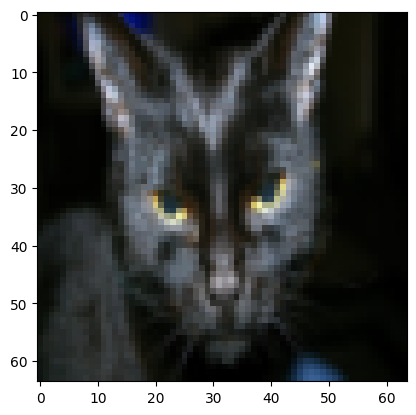

In [25]:
# Ví dụ về hình ảnh
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

Nhiều lỗi phần mềm trong deep learning là do có các chiều ma trận/vectơ không phù hợp. Nếu bạn có thể giữ cho chiều ma trận/vectơ của mình thẳng hàng, bạn sẽ loại bỏ được khá nhiều lỗi.

**Task 1:** Tìm giá trị:
    - m_train (số ví dụ huấn luyện)
    - m_test (số ví dụ kiểm tra)
    - num_px (= chiều cao = chiều rộng của hình ảnh huấn luyện)
Nhớ rằng `train_set_x_orig` là một mảng numpy của shape (m_train, num_px, num_px, 3). Ví dụ, bạn có thể truy cập `m_train` bằng cách nhập `train_set_x_orig.shape[0]`.

In [32]:
### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 3 dòng code)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
### KẾT THÚC CODE Ở ĐÂY ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Kỳ vọng đầu ra cho m_train, m_test và num_px**: 
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> 64 </td> 
  </tr>
  
</table>


Để thuận tiện, bây giờ chúng ta nên định hình lại hình ảnh của shape (num_px, num_px, 3) trong mảng numpy của shape (num_px $*$ num_px $*$ 3, 1). Sau đó, tập dữ liệu huấn luyện (và kiểm tra) của chúng ta là một mảng numpy trong đó mỗi cột đại diện cho một flattened image. Phải có m_train (tương ứng m_test) cột.

**Task 2:** Định hình lại các tập dữ liệu huấn luyện và kiểm tra để hình ảnh có size (num_px, num_px, 3) được làm phẳng thành các vectơ duy nhất có shape (num\_px $*$ num\_px $*$ 3, 1).

Có một mẹo để làm phẳng một ma trận X có shape (a,b,c,d) thành ma trận X_flatten có shape (b$*$c$*$d, a) là dùng:
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T là chuyển vị của X
```

In [33]:
# Định hình lại các ví dụ huấn luyện và kiểm tra

### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 2 dòng code)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T 
### KẾT THÚC CODE Ở ĐÂY ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [34]:
train_set_x_orig.shape

(209, 64, 64, 3)

**Kỳ vọng đầu ra**: 

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>**sanity check after reshaping**</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

Để biểu diễn hình ảnh màu, các kênh red (màu đỏ), green (xanh lá) và blue (xanh lục) (RGB) phải được chỉ định cho mỗi pixel (điểm ảnh) và do đó giá trị pixel thực sự là một vectơ gồm ba số từ 0 đến 255.

Một bước tiền xử lý phổ biến trong machine learning là căn giữa và chuẩn hóa tập dữ liệu, nghĩa là lấy giá trị trung bình của toàn bộ mảng numpy từ mỗi ví dụ, sau đó chia mỗi ví dụ cho độ lệch chuẩn của toàn bộ mảng numpy. Nhưng đối với tập dữ liệu hình ảnh, nó đơn giản, thuận tiện hơn và hoạt động gần như tốt khi chỉ cần chia mỗi hàng của tập dữ liệu cho 255 (giá trị tối đa của một kênh pixel).

<!-- Trong quá huấn luyện mô hình, chúng ta sẽ nhân trọng số và thêm độ lệch vào một số đầu vào ban đầu để quan sát sự kích hoạt của nơ-ron. Sau đó, truyền ngược với các gradient để huấn luyện mô hình. Tuy nhiên, điều cực kỳ quan trọng đối với mỗi đối tượng là phải có một phạm vi tương tự để các gradient của chúng ta không bị nổ. Chúng ta sẽ thấy điều đó chi tiết hơn ở phần sau của các bài giảng. !--> 

Hãy chuẩn hóa tập dữ liệu.

In [35]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

<font color='blue'>

**Những thứ cần nhớ:**

Các bước phổ biến để xử lý trước một tập dữ liệu mới là:
- Tìm ra các kích thước và hình dạng của bài toán (m_train, m_test, num_px, ...)
- Định hình lại các tập dữ liệu để mỗi ví dụ bây giờ là một vectơ có kích thước (num_px \* num_px \* 3, 1)
- "Chuẩn hóa" dữ liệu

## 3 - Kiến trúc chung của thuật toán học##

Đã đến lúc thiết kế một thuật toán đơn giản để phân biệt hình ảnh là cat (mèo) với non-cat.

Bạn sẽ xây dựng Hồi quy logistic, sử dụng tư duy Mạng nơ-ron. Hình sau giải thích lý do tại sao **Hồi quy Logistic thực sự là một mạng nơ-ron rất đơn giản!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Biểu thức toán học của thuật toán**:

Cho một ví dụ $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

Cost (chi phí) được tính bằng cách tổng tất cả các ví dụ huấn luyện:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Các bước chính**:
Trong tác vụ này, bạn sẽ thực hiện các bước sau: 
    - Khởi tạo các tham số của mô hình
    - Tìm hiểu các tham số cho mô hình bằng cách giảm thiểu chi phí  
    - Sử dụng các tham số đã học để đưa ra dự đoán (trên tập kiểm tra)
    - Phân tích kết quả và kết luận

## 4 - Xây dựng các phần của thuật toán ## 

Các bước chính để xây dựng Mạng nơ-ron là:
1. Xác định cấu trúc mô hình (chẳng hạn như số lượng các tính năng đầu vào) 
2. Khởi tạo các tham số của mô hình
3. Vòng lặp:
    - Tính toán loss hiện tại (lan truyền xuôi)
    - Tính toán gradient hiện tại (lan truyền ngược)
    - Cập nhật các tham số (gradient descent)

Chúng ta thường xây dựng các bước 1-3 riêng biệt và tích hợp chúng thành một hàm là `model()`.

### 4.1 - Hàm trợ giúp

**Task 3**: Sử dụng code của bạn từ "Python Basics", triển khai `sigmoid()`. Như đã thấy trong hình trên, bạn cần tính $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ để đưa ra dự đoán. Sử dụng np.exp().

In [96]:
def sigmoid(z):
    """
    Tính sigmoid của z

    Đối số:
    z -- Mảng numpy hoặc vô hướng có kích thước bất kỳ.

    Trả về:
    s -- sigmoid(z)
    """

    ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 1 dòng code)
    s = 1 / (1 + np.exp(-z))
    ### KẾT THÚC CODE Ở ĐÂY ###
    
    return s

In [97]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Kỳ vọng đầu ra**: 

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 4.2 - Khởi tạo tham số

**Task 4:** Thực hiện khởi tạo tham số trong cell bên dưới. Chúng ta cần khởi tạo w dưới dạng vectơ gồm các số không. Nếu bạn không biết sử dụng hàm numpy nào, hãy tra cứu np.zeros() trong tài liệu của thư viện Numpy.

In [98]:
def initialize_with_zeros(dim):
    """
    Hàm này tạo một vectơ của 0 có shape (dim, 1) cho w và khởi tạo b bằng 0.
    
    Đối số:
    dim -- kích thước của vectơ w mà chúng ta muốn (hoặc trong trường hợp này là số tham số)
    
    Trả về:
    w -- vectơ đã khởi tạo có shape (dim, 1)
    b -- số vô hướng đã khởi tạo (tương ứng với độ chệch)
    """
    
    ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 1 dòng code)
    w = np.zeros((dim,1))
    b = 0
    ### KẾT THÚC CODE Ở ĐÂY ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [99]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**Kỳ vọng đầu ra**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

Với các đầu vào hình ảnh, w sẽ là shape (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - Truyền xuôi (Forward propagation) và Truyền ngược (Backward propagation)

Bây giờ các tham số của bạn đã được khởi tạo, bạn có thể thực hiện các bước truyền xuôi và ngược để nghiên cứu các tham số.

**Task 5:** Triển khai hàm `propagate()` để tính toán hàm chi phí và gradient.

**Gợi ý**:

Truyền xuôi:
- Bạn có X
- Tính $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- Tính hàm chi phí: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Đây là hai công thức bạn sẽ sử dụng: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [157]:
def propagate(w, b, X, Y):
    """
    Triển khai hàm chi phí và gradient cho lan truyền đã giải thích ở trên

    Đối số:
    w -- trọng số, một mảng numpy có kích thước (num_px * num_px * 3, 1)
    b -- độ chệch, một số vô hướng
    X -- dữ liệu có kích thước (num_px * num_px * 3, số ví dụ)
    Y -- vectơ true "label" (chưa 0 nếu là non-cat, 1 nếu là cat) có kích thước (1, số ví dụ)

    Trả về:
    cost -- chi phí negative log-likelihood cho hồi quy logistic
    dw -- gradient của loss với w, do đó shape tương tự như w
    db -- gradient của loss với b, do đó shape tương tự như b
    
    Mẹo:
    - Viết code từng bước một cho propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # TRUYỀN XUÔI (TỪ X TỚI COST)
    ### BẮT ĐẦU CODE Ở ĐÂY ### ≈ 2 dòng code
    A = sigmoid(np.dot(w.T, X) + b)  # tính toán kích hoạt
    cost = -1/m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))               # tính toán cost
    ### KẾT THÚC CODE Ở ĐÂY ###
    
    # TRUYỀN NGƯỢC (TÌM GRAD)
    ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 2 dòng code)
    dw = 1/m * np.dot(X, (A - Y).T)
    db = 1/m * np.sum(A - Y)
    ### KẾT THÚC CODE Ở ĐÂY ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [158]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,
                                                                                         1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


**Kỳ vọng đầu ra**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### d) Tối ưu hóa
- Chúng ta đã khởi tạo các tham số.
- Bạn cũng có thể tính toán hàm chi phí và gradient.
- Bây giờ, bạn muốn cập nhật các tham số bằng cách sử dụng gradient descent.

**Task 6:** Viết hàm tối ưu hóa. Mục tiêu là tìm hiểu $w$ và $b$ bằng cách tối thiểu hóa hàm chi phí $J$. Đối với tham số $\theta$, quy tắc cập nhật là $ \theta = \theta - \alpha \text{ } d\theta$, trong đó $\alpha$ là tốc độ học.

In [159]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    Hàm này tối ưu hóa w và b bằng cách chạy thuật toán gradient descent
    
    Đối số:
    w -- trọng số, một mảng numpy có kích thước (num_px * num_px * 3, 1)
    b -- độ chệch, một số vô hướng
    X -- dữ liệu có shape (num_px * num_px * 3, số ví dụ)
    Y -- vectơ true "label" (0 nếu là non-cat, 1 nếu là cat), có shape (1, số ví dụ)
    num_iterations -- số lần lặp của vòng lặp tối ưu
    learning_rate -- tốc độ học của quy tắc cập nhật gradient descent
    print_cost -- nếu là True thì in ra loss sau mỗi 100 bước
    
    Trả về:
    params -- dictionary chứa trọng số w và độ chệch b
    grads -- dictionary chứa gradient của trọng số và độ chệch liên quan tới hàm chi phí 
    costs -- danh sách tất cả các chi phí đã tính toán trong quá trình tối ưu hóa, chúng ta sẽ sử dụng điều này sẽ vẽ đồ thị học.
    
    Mẹo:
    Về cơ bản chúng ta cần viết thành 2 bươc và lặp qua chúng:
        1) Tính chi phí và gradient cho các tham số hiện tại. Sử dụng propagate().
        2) Cập nhật các tham số sử dụng quy tắc gradient descent cho w và b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Tính chi phí và gradient (≈ 1-4 dòng code)
        ### BẮT ĐẦU CODE Ở ĐÂY ### 
        grads,cost = propagate(w, b, X, Y)
        ### KẾT THÚC CODE Ở ĐÂY ###
        
        # Truy xuất đạo hàm từ grads
        dw = grads["dw"]
        db = grads["db"]
        
        # quy tắc cập nhật (≈ 2 dòng code)
        ### BẮT ĐẦU CODE Ở ĐÂY ###
        w = w - dw*learning_rate
        b = b - db*learning_rate
        ### KẾT THÚC CODE Ở ĐÂY ###
        
        # Ghi các chi phí
        if i % 100 == 0:
            costs.append(cost)
        
        # In ra chí phí sau mỗi 100 ví dụ huấn luyện
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [160]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


**Kỳ vọng đầu ra**: 

<table style="width:40%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.19033591]
 [ 0.12259159]] </td>
    </tr>
    
    <tr>
       <td> **b** </td>
       <td> 1.92535983008 </td>
    </tr>
    <tr>
       <td> **dw** </td>
       <td> [[ 0.67752042]
 [ 1.41625495]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.219194504541 </td>
    </tr>

</table>

**Task 7:** Hàm trước đó sẽ xuất ra w và b đã tính. Chúng ta có thể sử dụng w và b để dự đoán các nhãn cho tập dữ liệu X. Thực hiện hàm `predict()`. Có 2 bước để tính các dự đoán:

1. Tính $\hat{Y} = A = \sigma(w^T X + b)$

2. Chuyển các mục nhập của a thành 0 (nếu kích hoạt <= 0.5) hoặc 1 (nếu kích hoạt > 0.5), lưu các dự đoán trong vectơ `Y_prediction`. Nếu muốn, bạn có thể sử dụng câu lệnh `if`/`else` trong vòng lặp `for` (mặc dù cũng có một cách để vectơ hóa điều này). 

In [161]:
def predict(w, b, X):
    '''
    Dự đoán xem nhãn là 0 hay 1 sử dụng các tham số hồi quy logistic đã tìm hiểu (w, b)
    
    Đối số:
    w -- trọng số, mảng numpy có kích thước (num_px * num_px * 3, 1)
    b -- độ chệch, số vô hướng
    X -- dữ liệu có kích thước (num_px * num_px * 3, số ví dụ)
    
    Trả về:
    Y_prediction -- mảng numpy (vectơ) chứa toàn bộ dự đoán (0/1) cho các ví dụ trong X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    # Tính vectơ "A" dự đoán xác suất để mèo có mặt trong hình
    ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 1 dòng code)
    A = np.dot(X.T,w) + b
    ### KẾT THÚC CODE Ở ĐÂY ###
    for i in range(A.shape[0]):
        # Chuyển xác suất A[0,i] thành dự đoán thực p[0,i]
        ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 4 dòng code)
        if np.sum(A[i,0]) > 0:
            Y_prediction[0][i] = 1
        else:
            Y_prediction[0][i] = 0


        
        ### KẾT THÚC CODE Ở ĐÂY ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [162]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


**Kỳ vọng đầu ra**: 

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>


<font color='blue'>

**Những điều cần nhớ:**
Chúng ta đã triển khai một số hàm:
- Khởi tạo (w,b)
- Tối ưu hóa loss lặp lại để tìm hiểu các tham số (w,b):
    - tính hàm chi phí và gradient 
    - cập nhật các tham số bằng cách sử dụng gradient descent
- Sử dụng (w,b) đã học để dự đoán các nhãn cho một tập ví dụ nhất định

## 5 - Hợp nhất tất cả các hàm thành một mô hình ##

Bây giờ bạn sẽ thấy mô hình tổng thể được cấu trúc như thế nào bằng cách tập hợp tất cả các khối xây dựng (các hàm được triển khai trong các phần trước) lại với nhau theo đúng thứ tự.

**Task 8:** Thực hiện hàm model. Sử dụng ký hiệu sau:
    - Y_prediction cho các dự đoán trong tập kiểm tra
    - Y_prediction_train cho các dự đoán trong tập huấn luyện
    - w, costs, grads cho các đầu ra của optimize()

In [170]:
ff = np.ones((3,6))
ff.shape

(3, 6)

In [167]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Xây dựng mô hình hồi quy logistic bằng cách gọi hàm mà chúng ta đã triển khai trước đó
    
    Đối số:
    X_train -- tập huấn luyện được biểu diễn bằng mảng numpy có shape (num_px * num_px * 3, m_train)
    Y_train -- nhãn huấn luyện được biểu diễn bằng mảng numpy (vectơ) có shape (1, m_train)
    X_test -- tập kiểm tra được biểu diễn bằng mảng numpy có shape (num_px * num_px * 3, m_test)
    Y_test -- nhãn kiểm tra được biểu diễn bằng mảng numpy (vectơ) có shape (1, m_test)
    num_iterations -- siêu tham số thể hiện số lần lặp để tối ưu hóa các tham số
    learning_rate -- siêu tham số thể hiện tốc độ học được sử dụng trong quy tắc cập nhật của optimize()
    print_cost -- Đặt thành true để in ra cost sau mỗi 100 lần lặp
    
    Trả về:
    d -- dictionary chứa thông tin về mô hình.
    """
    
    ### BẮT ĐẦU CODE Ở ĐÂY ###
    # khởi tạo tham số với 0 (≈ 1 dòng code)
    ww = np.zeros((X_train.shape[0],1))
    # Gradient descent (≈ 1 dòng code)
    parameters ,grads, costs = optimize(ww,0, X_train, Y_train, num_iterations, learning_rate, print_cost = False)
    # Truy xuất các tham số w và b từ dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Dự đoán các ví dụ của tập huấn luyện/kiểm tra (≈ 2 dòng code)
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    ### KẾT THÚC CODE Ở ĐÂY ###

    # In ra lỗi huấn luyện/kiểm tra
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Chạy cell sau để huấn luyện mô hình.

In [171]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Kỳ vọng đầu ra**: 

<table style="width:40%"> 

    <tr>
        <td> **Cost after iteration 0 **  </td> 
        <td> 0.693147 </td>
    </tr>
      <tr>
        <td> <center> $\vdots$ </center> </td> 
        <td> <center> $\vdots$ </center> </td> 
    </tr>  
    <tr>
        <td> **Train Accuracy**  </td> 
        <td> 99.04306220095694 % </td>
    </tr>

    <tr>
        <td>**Test Accuracy** </td> 
        <td> 70.0 % </td>
    </tr>
</table> 




**Nhận xét**: Độ chính xác của việc huấn luyện gần 100%. Đây là một kiểm tra tỉnh táo (sanity check) khá tốt: mô hình đang hoạt động và có dung lượng đủ để khớp với dữ liệu huấn luyện. Kiểm tra sai số là 68%. Nó thực sự không tệ đối với mô hình đơn giản này, với tập dữ liệu nhỏ mà chúng ta đã sử dụng và hồi quy logistic là một bộ phân loại tuyến tính. Nhưng đừng lo lắng, chúng ta sẽ xây dựng một bộ phân loại thậm chí còn tốt hơn vào tuần tới!

Ngoài ra, chúng ta thấy rằng mô hình rõ ràng đang bị quá khớp (overfit)với dữ liệu huấn luyện. Sau đó trong chuyên ngành này, các bạn sẽ học cách giảm thiểu overfitting, chẳng hạn bằng cách sử dụng điều chuẩn. Sử dụng đoạn code dưới đây (và thay đổi biến ``index`) để xem các dự đoán trên hình ảnh của tập kiểm tra.

y = 0, you predicted that it is a "cat" picture.


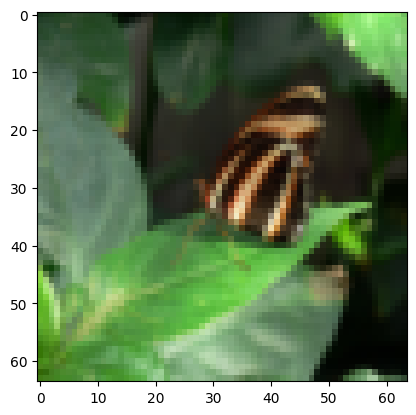

In [172]:
# Ví dụ về bức hình bị phân loại sai.
index = 5
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

Hãy vẽ biểu đồ của hàm chi phí và gradient.

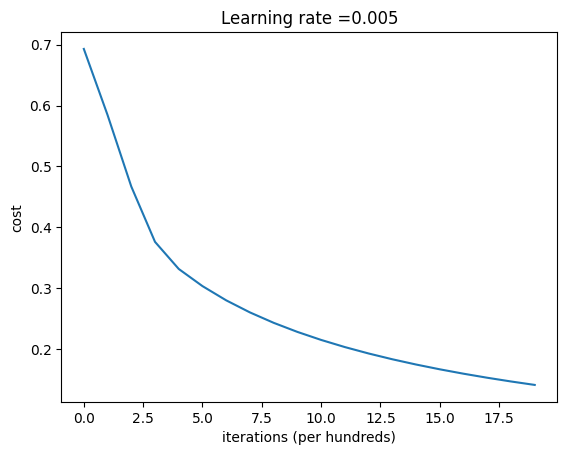

In [173]:
# Vẽ đồ thị học (với costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Diễn giải**:
Chúng ta thấy chi phí (cost) giảm dần. Điều này cho thấy rằng các tham số đang được học. Tuy nhiên, chúng ta có thể huấn luyện mô hình nhiều hơn nữa trên tập huấn luyện. Cố gắng tăng số lần lặp lại trong cell ở trên và chạy lại các cell. Chúng ta có thể thấy rằng độ chính xác của tập huấn luyện tăng lên, nhưng độ chính xác của tập kiểm tra sẽ giảm xuống. Điều này được gọi là overfitting.

## 6 - Phân tích thêm (tác vụ tùy chọn) ##

Chúc mừng bạn đã xây dựng mô hình phân loại hình ảnh đầu tiên. Hãy phân tích kỹ hơn và kiểm tra các lựa chọn khả thi cho tốc độ học  $\alpha$.

#### Lựa chọn tốc độ học ####

**Nhăc nhở**:
Để Gradient Descent hoạt động, cần chọn tốc độ học một cách khôn ngoan. Tốc độ học $\alpha $ xác định tốc độ chúng ta cập nhật các tham số. Nếu tốc độ học quá lớn, chúng ta có thể "vượt quá" giá trị tối ưu. Tương tự, nếu nó quá nhỏ, chúng ta sẽ cần rất nhiều lần lặp để hội tụ đến các giá trị tốt nhất. Đó là lý do tại sao cần sử dụng một tốc độ học được điều chỉnh tốt.

Hãy so sánh đồ thị học của mô hình với một số lựa chọn về tốc độ học. Chạy cell bên dưới. Quá trình này sẽ mất khoảng 1 phút. Vui lòng thử các giá trị khác với 3 giá trị mà chúng ta đã khởi tạo biến `learning_rates` để chứa và xem điều gì sẽ xảy ra.

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



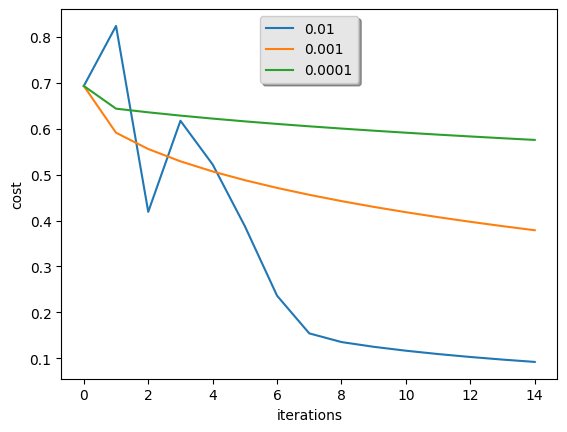

In [174]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Diễn giải**: 
- Các tốc độ học khác nhau cho các cost (chi phí) khác nhau và do đó các kết quả dự đoán khác nhau.
- Nếu tốc độ học quá lớn (0,01), cost có thể dao động lên xuống. Nó thậm chí có thể khác nhau (mặc dù trong ví dụ này, sử dụng 0,01 cuối cùng vẫn cho cost giá trị tốt).
- Cost thấp hơn không có nghĩa là mô hình tốt hơn. Bạn phải kiểm tra xem có khả năng overfitting hay không. Nó xảy ra khi độ chính xác huấn luyện cao hơn rất nhiều so với độ chính xác kiểm tra.
- Trong học tập sâu, chúng tôi thường khuyên bạn:
    - Chọn tốc độ học tốt hơn để giảm thiểu hàm chi phí.
    - Nếu mô hình bị overfit, hãy sử dụng các kỹ thuật khác để giảm overfitting. (Chúng ta sẽ nói về vấn đề này trong các video sau.)


## 7 - Kiểm tra hình ảnh của bạn (tác vụ tùy chọn) ##

Chúc mừng bạn đã hoàn thành lab này. Bạn có thể sử dụng hình ảnh của mình và xem đầu ra của mô hình của bạn. Để làm việc đó:
    1. Nhấp vào "File" ở thanh trên của notebook này, sau đó nhấp vào "Open" để truy cập Coursera Hub của bạn.
    2. Thêm hình ảnh của bạn vào thư mục của Jupyter Notebook này trong thư mục "images"
    3. Thay đổi tên hình ảnh của bạn trong code sau
    4. Chạy code và kiểm tra xem thuật toán có đúng không (1 = cat, 0 = non-cat)!

In [185]:
## BẮT ĐẦU CODE Ở ĐÂY ## (ĐẶT TÊN HÌNH ẢNH) 
my_image = ".jpg"   # đổi tên file ảnh
## KẾT THÚC CODE Ở ĐÂY ##

# Tiền xử lý hình ảnh để khớp với thuật toán.
fname = "images/" + my_image
image = Image.open(fname)
image = image.resize((num_px,num_px))

my_image = np.array(image).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)
plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

FileNotFoundError: [Errno 2] No such file or directory: 'images/.jpg'

<font color='blue'>

**Những điều cần nhớ từ lab này:**
1. Bước tiền xử lý tập dữ liệu khá là quan trọng.
2. Chúng ta đã triển khai từng hàm riêng biệt: initialize(), propagate(), optimize() rồi tạo một model().
3. Điều chỉnh tốc độ học (ví dụ về "siêu tham số") có thể tạo ra sự khác biệt lớn cho thuật toán. Bạn sẽ thấy thêm các ví dụ về điều này sau trong khóa học này!

Cuối cùng, nếu bạn muốn, chúng tôi mời bạn hãy thử những thứ khác nhau trên Notebook này. Những điều bạn có thể thử bao gồm:
    - Thử với learning rate và số lần lặp lại
    - Thử các phương pháp khởi tạo khác nhau và so sánh kết quả
    - Kiểm tra các tiền xử lý khác (căn giữa dữ liệu hoặc chia từng hàng theo độ lệch chuẩn của nó)

Tham khảo:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c